In [1]:
import pandas  as pd
import numpy as np
import pickle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

In [2]:
fmatfile = '../ppi_ml/data/featmats/featmat_labeled_traintest.pkl'
target = 'label'
seed = 13
train_size = 0.7
n_features_to_select = 100
#min_features_to_select = 1

In [3]:
# load data
with open(fmatfile, 'rb') as handle:
    fmat = pickle.load(handle)

# define cols
label_cols = ['ID', 'label', 'super_group']
data_cols = [c for c in fmat.columns.values.tolist() if c not in label_cols]

In [4]:
# convert cols to arrays
X = fmat[data_cols].to_numpy()
y = fmat[label_cols[1]].to_numpy()
groups = fmat[label_cols[2]].to_numpy()

In [5]:
# group split strategy
gss = GroupShuffleSplit(n_splits = 1, train_size=train_size, random_state=seed)

# model to train on
clf = ExtraTreesClassifier(n_estimators=100, random_state=seed)

# feature selector (rfe w/ cross-validation)
cv = StratifiedKFold(5)
rfecv = RFECV(
    estimator=clf,
    step=5,
    cv=cv,
    scoring="accuracy",
    n_jobs=5,
)

In [6]:
# get train & test splits
for test_idx, train_idx in gss.split(X, y, groups):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]
    
    label, counts = np.unique(y_train, return_counts=True)
    label_counts_train = dict(zip(label, counts))
    label, counts = np.unique(y_test, return_counts=True)
    label_counts_test = dict(zip(label, counts))
    
    print(f'# train PPIs = {len(X_train)}')
    print(f' --> +/- label balance: {label_counts_train}')
    print(f'# test PPIs = {len(X_test)}')
    print(f' --> +/- label balance: {label_counts_test}')

# train PPIs = 18339
 --> +/- label balance: {-1: 13400, 1: 4939}
# test PPIs = 6902
 --> +/- label balance: {-1: 5212, 1: 1690}


In [7]:
# execute rfe with cross-validation
rfecv.fit(X_train, y_train)
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 148


In [8]:
rfecv.classes_

array([-1,  1])

NameError: name 'min_features_to_select' is not defined

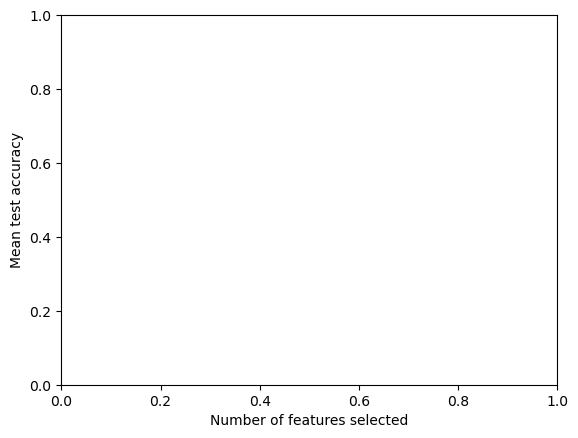

In [9]:
# results ...?
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure().tight_layout()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
result = permutation_importance(
    rfecv, X_test, y_test, n_repeats=5, random_state=13, n_jobs=5
)

X_df = fmat[data_cols]

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_df.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.rc('ytick', labelsize=6) 
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
# results ...?
predictions = rfecv.predict(X_test)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(rfecv, X_test, y_test)
plt.savefig(f'test.png', dpi=300, transparent=True)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

In [ ]:
len(y_train)

In [ ]:
df = pd.DataFrame()
df[['precision','recall']] = precision, recall

In [ ]:
results = pd.DataFrame({'feature':data_cols, 'rank':rfecv.ranking_, 'support':rfecv.support_})
results

In [ ]:
sel_feats = results[results['support'] == True]
sel_feats

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease (MDI) within each tree.

From documentation: "In scikit-learn, we implement the importance as described in [1] (often cited, but unfortunately rarely read…). It is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble."

**Warning:** Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance as an alternative: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [ ]:
rfecv.estimator_.feature_importances_

In [ ]:
sel_feats_scored = sel_feats.head(rfecv.n_features_)
sel_feats_scored['mdi'] = rfecv.estimator_.feature_importances_
sel_feats_scored = sel_feats_scored.sort_values('mdi')

In [ ]:
sel_feats_scored

In [ ]:
# write output
sel_feats_scored.to_csv('../ppi_ml/results/feature_selection/selected_feats_extratrees.csv', index=False)